In [1]:
import numpy as np 
%matplotlib inline 
import matplotlib.pylab as plt
import time

# Stommel Two box model

In [2]:
class Stommel(object):
    def __init__(self, members=1, n=20, dt=0.05, alpha=1e-4, beta=8*1e-4, k=10, H=0.0125, gamma=10, T1_bar = 270., T2_bar=290.,dS=0):  
        #E = 0.249999
        self.dS = dS
        self.n = n
        self.dt = dt
        self.data = np.zeros((4,members, n))
        self.data[0,:,:] = (np.random.randn(members, n)/100.+1.)*T1_bar #---T1
        self.data[1,:,:] = (np.random.randn(members, n)/100.+1.)*T2_bar #---T2
        self.data[2,:,:] = (np.random.randn(members, n)/100.+1.)*35     #---S1
        self.data[3,:,:] = (np.random.randn(members, n)/100.+1.)*(35+dS)#---S2
        self.members = members
        self.alpha = alpha
        self.beta = beta
        self.k = k
        self.H = H  #---surface salinity flux
        self.gamma = gamma
        self.T1_bar = T1_bar
        self.T2_bar = T2_bar
        self.q = []

    # q is the thermohaline circulation strength s^-1
    # q>0 >>> poleward surface flow, temperature difference dominates the salinity difference in their influence on density
    # q<0 >>> equatorward surface flow
    def get_q(self,delT,delS):
        q = self.k*(self.alpha*delT-self.beta*delS)
        return q
    
    def dxdt(self):
        dxdt = np.zeros((4,self.members, self.n),'f8')
        for n in range(0,self.n):
            dxdt[0,:,n] = -np.abs(self.q[:,n]) * (self.data[1,:,n]-self.data[0,:,n]) + self.gamma * (self.T1_bar-self.data[0,:,n])  
            dxdt[1,:,n] = np.abs(self.q[:,n]) * (self.data[1,:,n]-self.data[0,:,n]) + self.gamma * (self.T2_bar-self.data[1,:,n])
        for n in range(0,self.n):
            dxdt[2,:,n] = np.abs(self.q[:,n]) * (self.data[3,:,n]-self.data[2,:,n]) - self.H 
            dxdt[3,:,n] = -np.abs(self.q[:,n]) * (self.data[3,:,n]-self.data[2,:,n]) + self.H
        return dxdt

    
    def rk4step(self):
        self.q = self.get_q(self.data[1,:,:]-self.data[0,:,:],self.data[3,:,:]-self.data[2,:,:])
        h = self.dt; hh = 0.5*h; h6 = h/6.
        x = self.data
        dxdt1 = self.dxdt()
        self.data = x + hh*dxdt1
        dxdt2 = self.dxdt()
        self.data = x + hh*dxdt2
        dxdt = self.dxdt()
        self.data = x + h*dxdt
        dxdt2 = 2.0*(dxdt2 + dxdt)
        dxdt = self.dxdt()
        self.data = x + h6*(dxdt1 + dxdt + dxdt2) 
    
    #--- DATA ASSIMILATION PART
    def get_xb(self,x,H1,R):
        xb_bar = x.mean(axis=0)
        xb_prime = x-xb_bar 
        Pb = np.sum(xb_prime[:,np.newaxis,:]*xb_prime[:,:,np.newaxis],axis=0)/(self.members-1)
        K = np.dot(np.dot(Pb,H1.T),np.linalg.inv(np.dot(np.dot(H1,Pb),H1.T)+R))
        return xb_bar, xb_prime, Pb, K
    
    def assim(self,obs_std,x,mx,H1):
        obs = np.dot(H1,mx)
        obs += (np.random.randn(len(obs))/100.+1.)*3
        N_obs = len(obs)
        R = obs_std**2*np.eye(N_obs)
        xb_bar, xb_prime, Pb, K = self.get_xb(x,H1,R)
        dim = np.shape(Pb)
        I = np.eye(dim[0],dim[1])
        xa_bar = xb_bar+np.dot(K,(obs-np.dot(H1,xb_bar)))
        dim = xb_prime.shape
        obs_prime = obs_std*np.random.randn(self.members,N_obs)
        xa_prime = np.zeros((self.members,dim[1]))
        xa = np.zeros_like(xa_prime)
        for i in range(self.members):
            xa_prime[i,:] = xb_prime[i,:]+np.dot(K,(obs_prime[i,:]-np.dot(H1,xb_prime[i,:])))
            xa[i,:] = xa_bar+xa_prime[i,:] 
        return xa    


Calculate the equilibrium state roots

In [17]:
alpha = 1e-4
delT = 20
beta = 8*1e-4
delS = 10
X = alpha*delT
#K = 4*1e4
K = 10
E = np.linspace(0.,0.249999999,50)
H = E/beta*K*X**2
#---Y<X
E1 = np.linspace(0.,0.5,100)
H1 = E1/beta*K*X**2
Y = X*(0.5+np.sqrt(1./4.+beta*H1/K/X**2))  
#---Y>X
Y2 = X*(0.5+np.sqrt(1./4.-beta*H/K/X**2))
Y3 = X*(0.5-np.sqrt(1./4.-beta*H/K/X**2))
qq1 = K*(alpha*delT-Y)
qq2 = K*(alpha*delT-Y2)
qq3 = K*(alpha*delT-Y3)

# The model result when varying surface salinity flux

In [4]:
def run_model(model,step,HH):
    T1=[]
    T2=[]
    S1=[]
    S2=[]
    q=[]
    for i in range(0,step):
        model.H = HH[i]
        model.rk4step()
        T1 = np.append(T1,model.data[0].mean())
        T2 = np.append(T2,model.data[1].mean())
        S1 = np.append(S1,model.data[2].mean())
        S2 = np.append(S2,model.data[3].mean())
        q = np.append(q,model.q.mean()) 
    return T1,T2,S1,S2,q

run model as H increases, dS = 0

In [5]:
m1 = Stommel(dS=0)
step = 10000
HH = np.linspace(0.,0.025,step)
T1_1,T2_1,S1_1,S2_1,q1 = run_model(m1,step,HH)
print(m1.data[0].mean(),m1.data[1].mean(),m1.data[2].mean(),m1.data[3].mean())

269.985731141 290.014268859 33.2184846267 36.6127916023


run model as H decreases, dS = 0

In [6]:
m2 = Stommel(dS=0)
HH2 = np.linspace(0.025,0.,step)
T1_2,T2_2,S1_2,S2_2,q2 = run_model(m2,step,HH2)
print(m2.data[0].mean(),m2.data[1].mean(),m2.data[2].mean(),m2.data[3].mean())

269.99909251 290.00090749 33.6482087832 36.2048557388


run model as H increases, dS = 2.5

In [7]:
m3 = Stommel(dS=2.5)
T1_3,T2_3,S1_3,S2_3,q3 = run_model(m3,step,HH)
print(m3.data[0].mean(),m3.data[1].mean(),m3.data[2].mean(),m3.data[3].mean())

269.98571245 290.01428755 34.4869481943 37.8824145304


run model as H decreases, dS = 2.5

In [8]:
start_time = time.time()
m4 = Stommel(dS=2.5)
T1_4,T2_4,S1_4,S2_4,q4 = run_model(m4,step,HH2)
print(m4.data[0].mean(),m4.data[1].mean(),m4.data[2].mean(),m4.data[3].mean())
print("--- %s seconds ---" % (time.time() - start_time))

269.99909251 290.00090749 34.9734702047 37.5301171606
--- 27.185894012451172 seconds ---


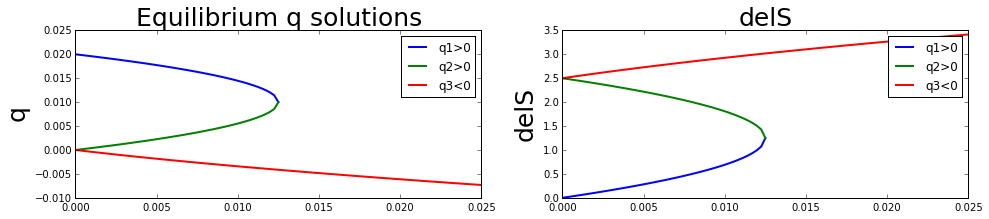

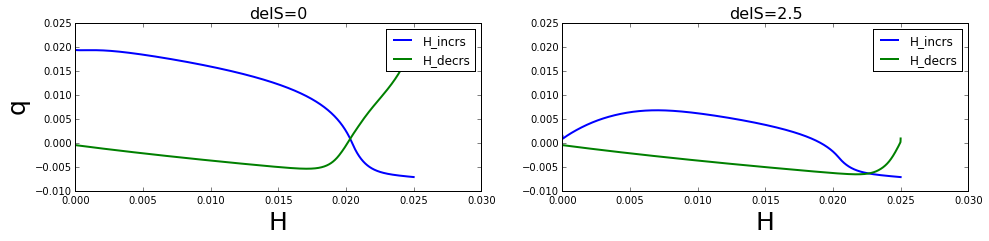

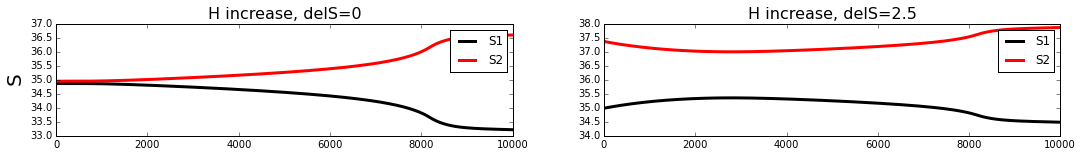

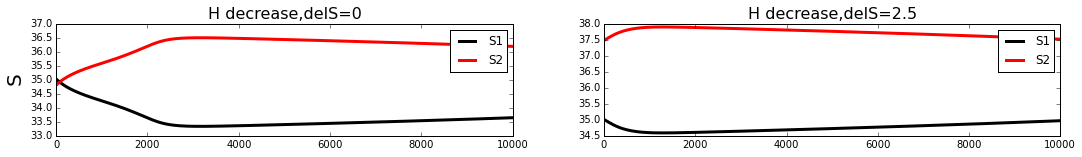

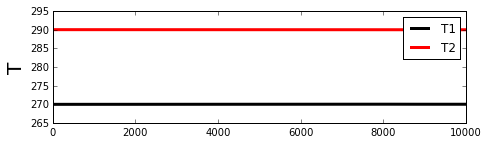

In [18]:
f,ax = plt.subplots(1,2)
f.set_size_inches(16,3,forward=True)
ax[0].plot(H,qq3,lw=2,label='q1>0')
ax[0].plot(H,qq2,lw=2,label='q2>0')
ax[0].plot(H1,qq1,lw=2,label='q3<0')
ax[0].legend()
ax[0].set_ylabel('q',fontsize=25)
ax[0].set_title('Equilibrium q solutions',fontsize=25)
ax[1].plot(H,Y3/beta,lw=2,label='q1>0')
ax[1].plot(H,Y2/beta,lw=2,label='q2>0')
ax[1].plot(H1,Y/beta,lw=2,label='q3<0')
ax[1].legend()
ax[1].set_ylabel('delS',fontsize=25)
ax[1].set_title('delS',fontsize=25)

f,ax = plt.subplots(1,2)
f.set_size_inches(16,3,forward=True)
ax[0].plot(HH,q1,'b',lw=2,label = 'H_incrs')
ax[0].plot(HH2[::-1],q2[::-1],'g',lw=2,label='H_decrs')
ax[0].legend()
ax[0].set_ylabel('q',fontsize=25)
ax[0].set_title('delS=0',fontsize=16)
ax[0].set_xlabel('H',fontsize=25)
ax[1].plot(HH,q3,'b',lw=2,label = 'H_incrs')
ax[1].plot(HH2[::-1],q4[::-1],'g',lw=2,label='H_decrs')
ax[1].legend()
#ax[1].ylabel('q',fontsize=25)
ax[1].set_ylim([-0.01,0.025])
ax[1].set_xlabel('H',fontsize=25)
ax[1].set_title('delS=2.5',fontsize=16)

#fig = plt.figure()
#fig.set_size_inches(7.8,2,forward=True)
#plt.plot(q,label='H_forward')
#plt.plot(q2,label='H_backward')
#plt.ylabel('q',fontsize=20)
#plt.xlabel('time',fontsize=20)
#plt.legend()

f,ax = plt.subplots(1,2)
f.set_size_inches(18,2,forward=True)
ax[0].plot(S1_1,'k',label='S1',lw=3)
ax[0].plot(S2_1,'r',label='S2',lw=3)
ax[0].set_ylabel('S',fontsize=20)
ax[0].legend()
ax[0].set_title('H increase, delS=0',fontsize=16)
ax[1].plot(S1_3,'k',label='S1',lw=3)
ax[1].plot(S2_3,'r',label='S2',lw=3)
#plt.ylabel('S',fontsize=20)
ax[1].legend()
ax[1].set_title('H increase, delS=2.5',fontsize=16)

f,ax = plt.subplots(1,2)
f.set_size_inches(18,2,forward=True)
ax[0].plot(S1_2,'k',label='S1',lw=3)
ax[0].plot(S2_2,'r',label='S2',lw=3)
ax[0].set_ylabel('S',fontsize=20)
ax[0].legend()
ax[0].set_title('H decrease,delS=0',fontsize=16)
ax[1].plot(S1_4,'k',label='S1',lw=3)
ax[1].plot(S2_4,'r',label='S2',lw=3)
ax[1].legend()
ax[1].set_title('H decrease,delS=2.5',fontsize=16)

fig = plt.figure()
fig.set_size_inches(7.4,2,forward=True)
plt.plot(T1_1,'k',label='T1',lw=3)
plt.plot(T2_1,'r',label='T2',lw=3)
plt.ylabel('T',fontsize=20)
plt.legend()


# Data Assimiliation, perturbed enkf

In [20]:
def run_assim(model,ens,obs_std,sim_len,cyc_len,mem,HH,H):
    ens.data[0] = model.data[0][0]+np.random.randn(mem,model.n)
    ens.data[1] = model.data[1][0]+np.random.randn(mem,model.n)
    ens.data[2] = model.data[2][0]+np.random.randn(mem,model.n)
    ens.data[3] = model.data[3][0]+np.random.randn(mem,model.n)
    error = []
    ensq = []
    mq = []
    for i in range(0,sim_len):
        ens.rk4step()
        ens.H = HH[i]
        model.rk4step()
        model.H = HH[i]
        if np.mod(i, cyc_len)==0:
            ens.data[0] = ens.assim(obs_std,ens.data[0],model.data[0][0],H)
            ens.data[1] = ens.assim(obs_std,ens.data[1],model.data[1][0],H)
            ens.data[2] = ens.assim(obs_std,ens.data[2],model.data[2][0],H)
            ens.data[3] = ens.assim(obs_std,ens.data[3],model.data[3][0],H)
        ensq = np.append(ensq,ens.q.mean())
        mq = np.append(mq,model.q.mean())
        error = np.append(error, np.mean(np.sqrt((model.q[0]-np.mean(ens.q,axis=0))**2)))
        if i == 0:
            hist_error = np.sqrt((model.q[0]-np.mean(ens.q,axis=0))**2)[np.newaxis,:]
        else:
            hist_error = np.append(hist_error,np.sqrt((model.q[0]-np.mean(ens.q,axis=0))**2)[np.newaxis,:],axis=0)
    return error, ensq, mq, hist_error

In [21]:
sim_len = 10000
cyc_len = 800
N_o = 20
mem = 20 
obs_std = 0.5 
h1 = np.eye(N_o)
#----fancy H 
#a = np.arange(0,N_o)
#H1 = np.ones(N_o)[np.newaxis,:]
#for i in range(1, N_o):
#    H1 = np.append(H1,np.cos(i*a/19.*np.pi)[np.newaxis,:],axis=0)

run model while H increasing

In [ ]:
m=Stommel(dS=0)
ens=Stommel(dS=0,members=mem)
start_time = time.time()
error1, ensq1, mq1, hist_error1 = run_assim(m,ens,obs_std,sim_len,cyc_len,mem,HH,h1)
print("--- %s seconds ---" % (time.time() - start_time))

run model while H decreasing

In [ ]:
m2=Stommel(dS=0)
ens2=Stommel(dS=0,members=mem)
error2, ensq2, mq2, hist_error2 = run_assim(m2,ens2,obs_std,sim_len,cyc_len,mem,HH2,h1)

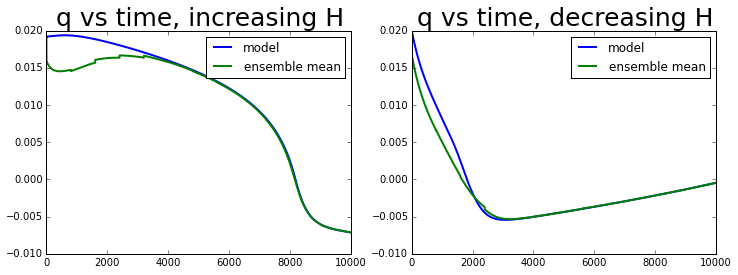

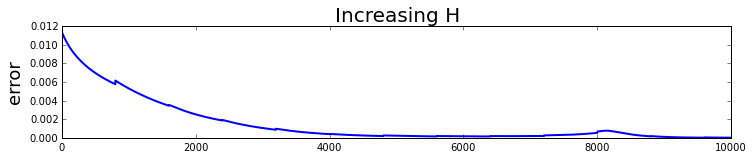

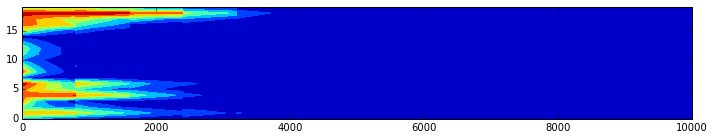

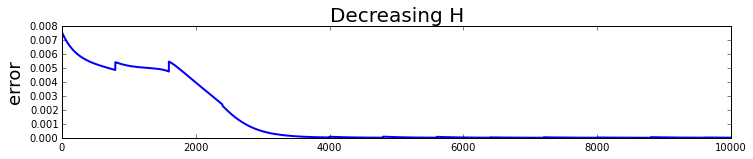

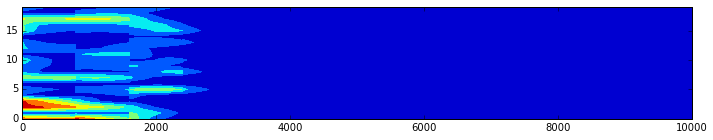

In [57]:
f,ax = plt.subplots(1,2)
f.set_size_inches(12,4,forward=True)
ax[1].plot(mq2,lw=2,label='model')
ax[1].plot(ensq2,lw=2,label='ensemble mean')
ax[1].set_title('q vs time, decreasing H',fontsize=25)
ax[1].legend()

ax[0].plot(mq1,lw=2,label='model')
ax[0].plot(ensq1,lw=2,label='ensemble mean')
ax[0].set_title('q vs time, increasing H',fontsize=25)
ax[0].legend()


fig = plt.figure()
fig.set_size_inches(12,2,forward=True)
plt.plot(error1,lw=2)
plt.title('Increasing H',fontsize=20)
plt.ylabel('error',fontsize=18)

fig = plt.figure()
fig.set_size_inches(12,2,forward=True)
plt.contourf(hist_error1.T)

fig = plt.figure()
fig.set_size_inches(12,2,forward=True)
plt.plot(error2,lw=2)
plt.title('Decreasing H',fontsize=20)
plt.ylabel('error',fontsize=18)

fig = plt.figure()
fig.set_size_inches(12,2,forward=True)
plt.contourf(hist_error2.T)